In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.python.ops import array_ops
import numpy as np
import matplotlib.pyplot as plt
import processes
from processes import orstein_uhlenbeck as ou
import utils
from utils import kalman
import buildingblocks
from buildingblocks import stupidcell

/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/apple/anaconda3/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Network

In [2]:
def build_optimizer(loss, learning_rate, grad_clip):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars))
    
    return optimizer

In [3]:

graph=tf.Graph()


In [4]:
logs_dir = './graphs/'
batch_size=128
num_steps=1095
lstm_layers= 1
lstm_size= 20
inputs_dim= 1
alpha = 0.1

In [5]:
with graph.as_default():
    inputs_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='inputs')
    targets_ = tf.placeholder( tf.float32, [batch_size,num_steps, inputs_dim] , name='targets')
    learning_rate= tf.placeholder( tf.float32 , name='lr')
    grad_clip= tf.placeholder( tf.float32 , name='clip')

In [6]:

with graph.as_default():
    cell = stupidcell.StupidRNNCell(1,activation= None)
    
    '''
    stupidlstm = stupidcell.StupidLSTMCell(lstm_size)
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    lstm= tf.contrib.rnn.MultiRNNCell([lstm,stupidlstm])
    '''
    lstm = stupidcell.StupidLSTMCell(lstm_size)
    
    W = tf.Variable(tf.random_normal([lstm_size, lstm_size]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ lstm_size]), dtype=tf.float32)
    def residual_wrapper( i,o):
        out = tf.matmul( o, W)+b
        out = tf.sigmoid( out)
        return array_ops.concat([i,out],1)
    lstm = tf.contrib.rnn.ResidualWrapper( lstm, residual_wrapper) 
    
    rnn_cell = tf.contrib.rnn.MultiRNNCell([lstm,cell])
# 'outputs' is a tensor of shape [batch_size, max_time, cell_state_size]

# defining initial state
    initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)

# 'state' is a tensor of shape [batch_size, cell_state_size]
    outputs, state = tf.nn.dynamic_rnn(rnn_cell, inputs_,
                                   initial_state=initial_state,
                                   dtype=tf.float32)
    '''
    W = tf.Variable(tf.random_normal([lstm_size, inputs_dim]), dtype=tf.float32) # weights
    b = tf.Variable(tf.random_normal([ inputs_dim]), dtype=tf.float32) # biases
    shape = outputs.shape
    
    outputs = tf.matmul( tf.reshape( outputs, [-1, lstm_size]), W ) + b
    outputs = tf.reshape( outputs, (shape[0],shape[1],b.shape[0]))
    '''


(128, 2)


In [7]:
with graph.as_default():
    square=  tf.reduce_mean( tf.square( outputs - targets_),axis=0 )
    shape = square.shape
    square = tf.reshape(square, [shape[0],])
    def power(x):
        alpha =0.96
        return (1-alpha)*tf.pow(alpha,x)
    weights = tf.map_fn(  power, tf.range( start= shape[0]-1, delta=-1., limit= -0.5  ) )
    cost = tf.losses.compute_weighted_loss( square, weights )
    optimizer= build_optimizer(cost, learning_rate, grad_clip)
    

## Batch

In [8]:


def batch_1( batch_size, num_steps, noise, dictionary,):
    while True:
        invariant_std = 0.3 +0.6*np.random.randint(2)
        rand = np.random.rand()
        lbd = 10**( (np.random.randint(3) -1 )*0.5 ) 
        sigma = invariant_std*np.sqrt(2*lbd)
        dictionary['sigma'] = sigma
        dictionary['lbd'] = lbd

        batch = np.random.randn( batch_size,num_steps+1,1)*noise
        trend =np.reshape( ou.process(**dictionary)[: num_steps+1] , [-1,1] )
        for i in range(batch_size):
            batch[i,:,:]=batch[i,:,:]+trend[:,:]
        
        yield (batch[:,:-1,:] , batch[:,1:,:],trend, dictionary )

    

In [9]:
invariant_std = 0.2
lbd = 1.
sigma = invariant_std*np.sqrt(2*lbd)
start= 365
dictionary = {'deltaT': 1./365,
              'T':3}
noise= 0.1/np.sqrt( dictionary['deltaT'])
generator1 = batch_1( batch_size , num_steps,noise ,dictionary)

In [10]:
generator= generator1

## Training

## Batch 1

{'Iteration:  99 \\/ 7000'}
-3.6465853476896894


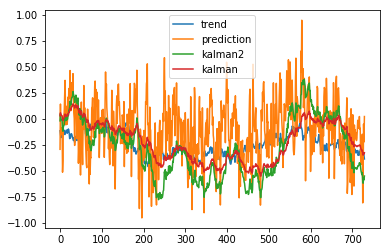

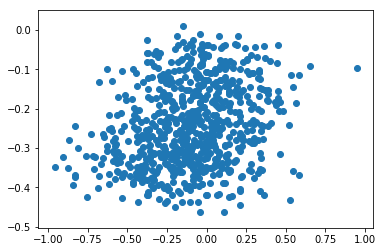

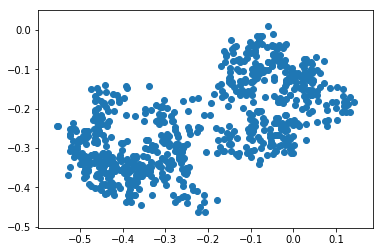

{'Iteration:  199 \\/ 7000'}
-3.6464342385064823


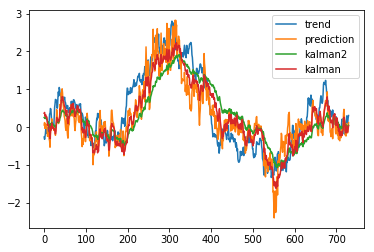

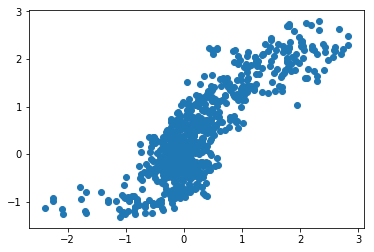

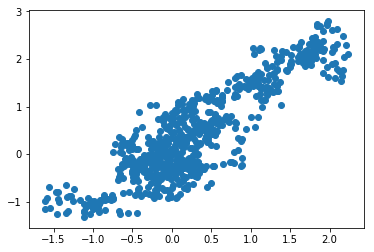

{'Iteration:  299 \\/ 7000'}
-3.6465037771035


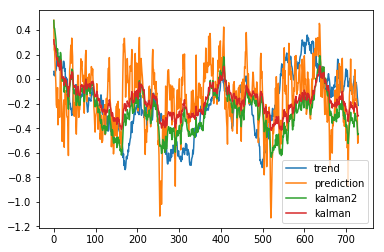

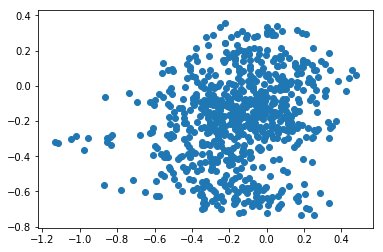

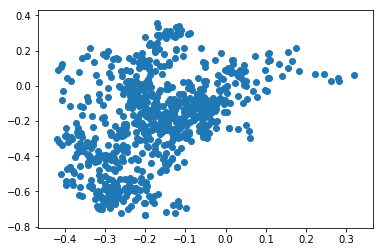

{'Iteration:  399 \\/ 7000'}
-3.646541416505353


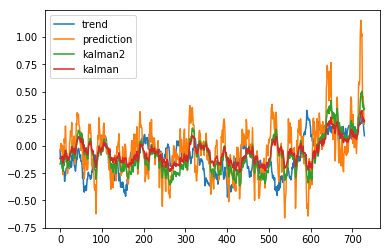

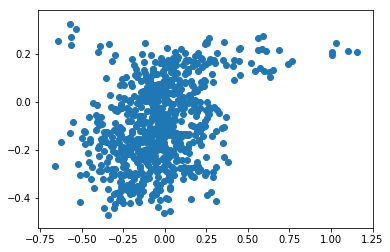

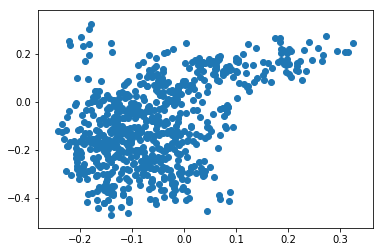

{'Iteration:  499 \\/ 7000'}
-3.646655389899389


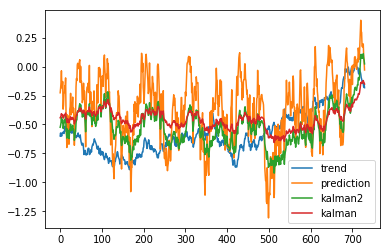

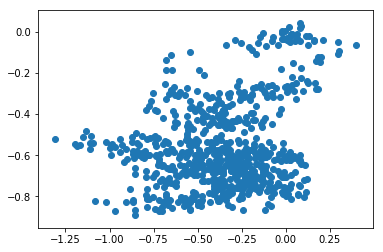

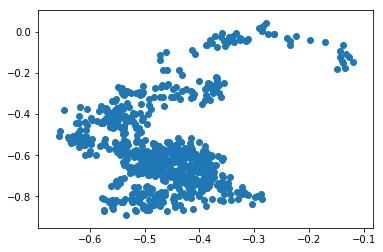

{'Iteration:  599 \\/ 7000'}
-3.6465857227798564


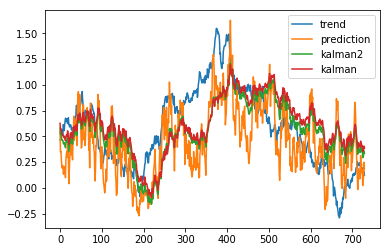

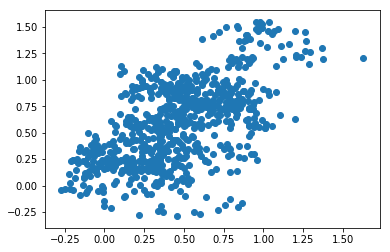

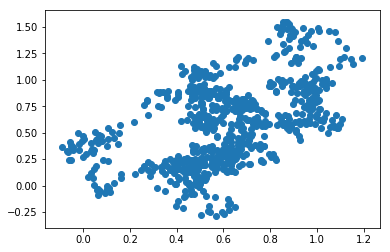

{'Iteration:  699 \\/ 7000'}
-3.6465190233197076


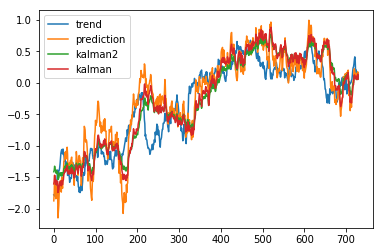

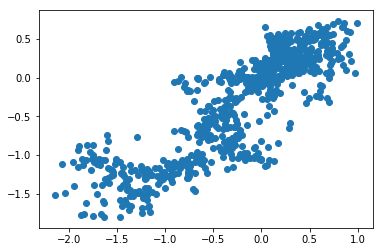

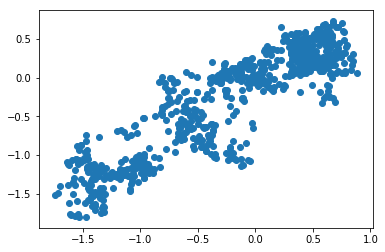

{'Iteration:  799 \\/ 7000'}
-3.6465605721808982


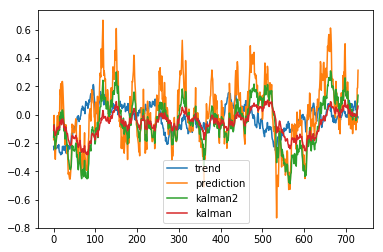

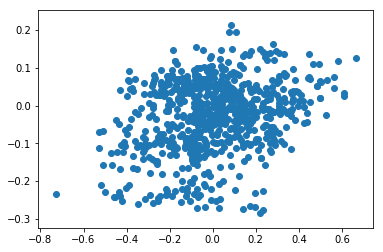

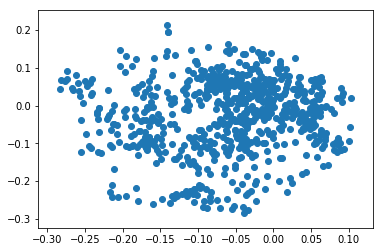

{'Iteration:  899 \\/ 7000'}
-3.646698036324234


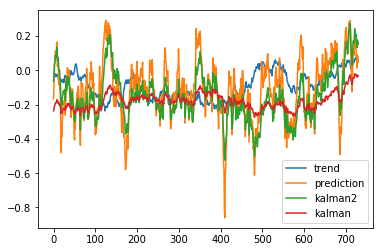

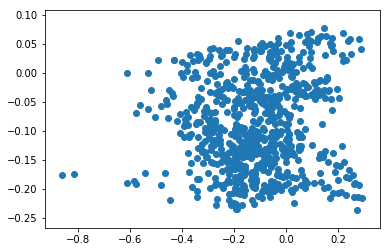

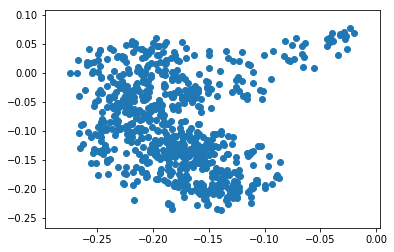

{'Iteration:  999 \\/ 7000'}
-3.6465246091596795


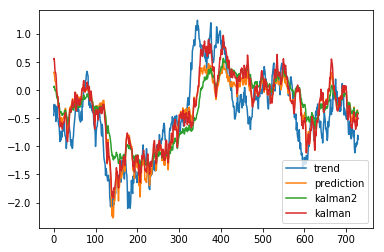

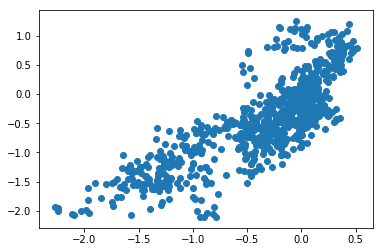

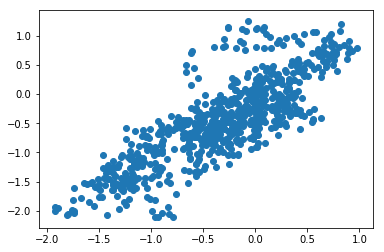

{'Iteration:  1099 \\/ 7000'}
-3.646608761372046


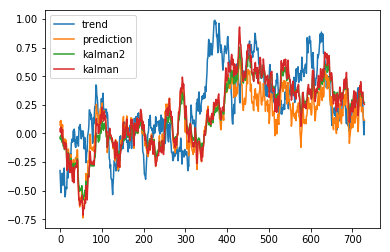

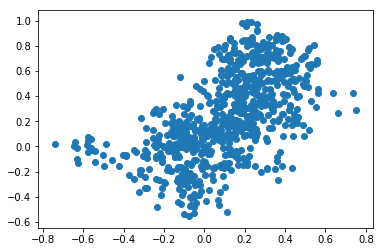

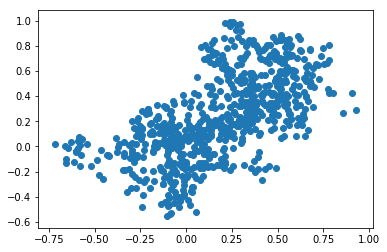

{'Iteration:  1199 \\/ 7000'}
-3.6466497777495546


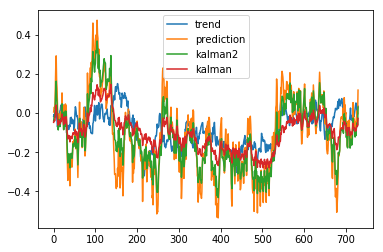

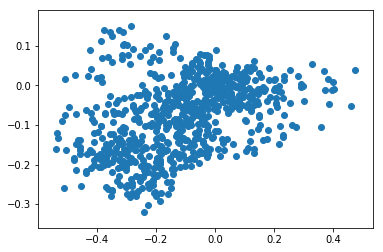

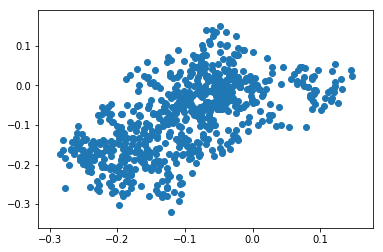

{'Iteration:  1299 \\/ 7000'}
-3.646591543313117


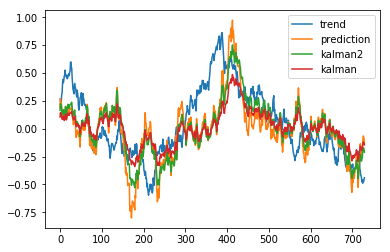

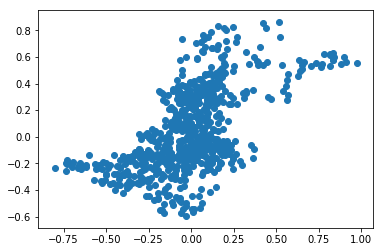

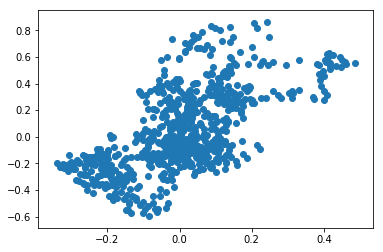

{'Iteration:  1399 \\/ 7000'}
-3.6464179417584104


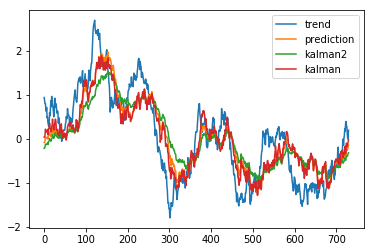

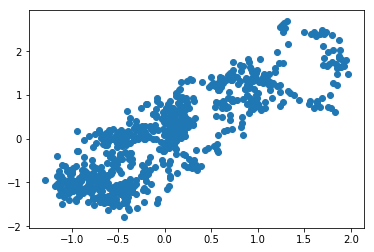

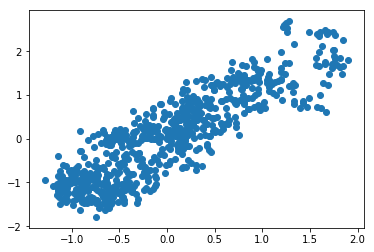

{'Iteration:  1499 \\/ 7000'}
-3.646620226884262


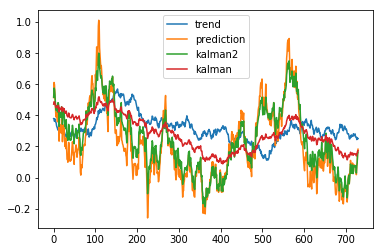

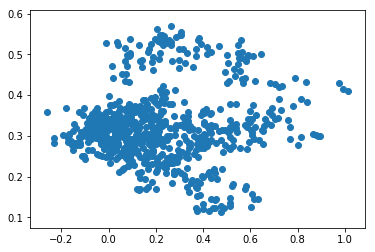

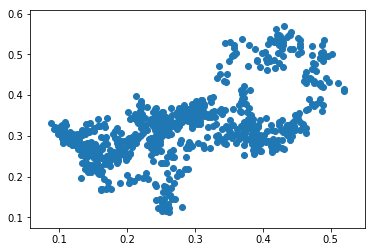

{'Iteration:  1599 \\/ 7000'}
-3.6466265102848423


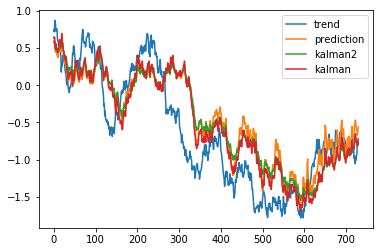

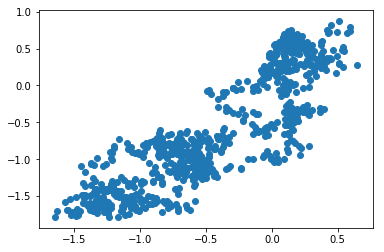

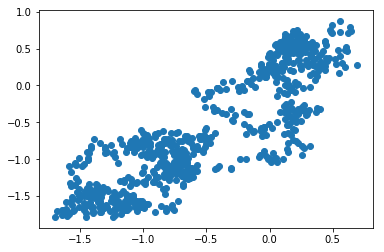

{'Iteration:  1699 \\/ 7000'}
-3.6466143004130585


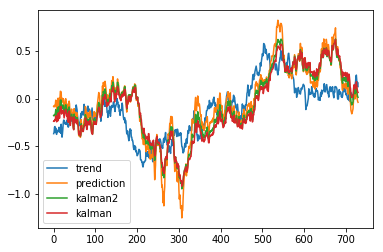

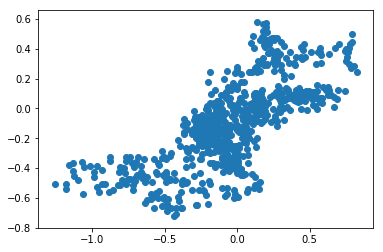

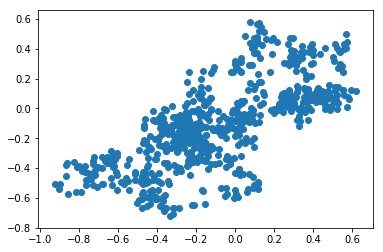

{'Iteration:  1799 \\/ 7000'}
-3.6465856925118727


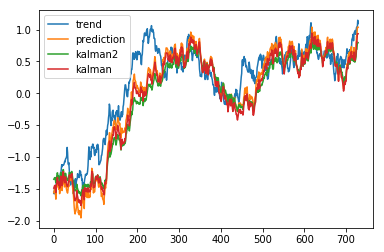

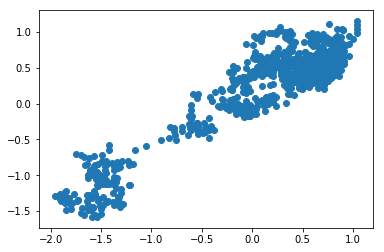

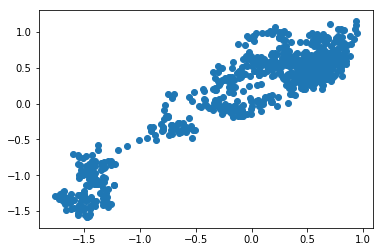

{'Iteration:  1899 \\/ 7000'}
-3.6466044942848397


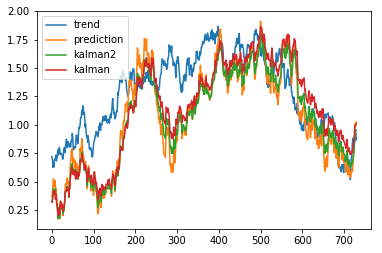

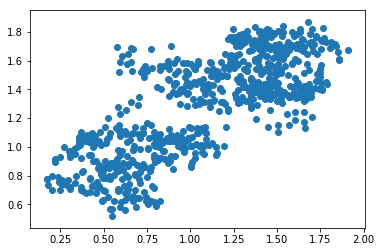

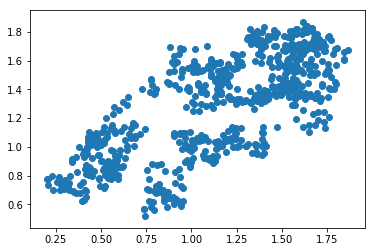

{'Iteration:  1999 \\/ 7000'}
-3.646295755961911


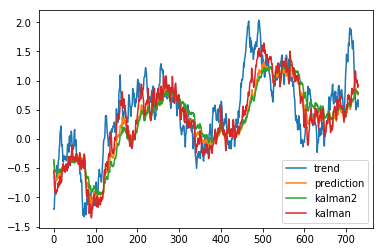

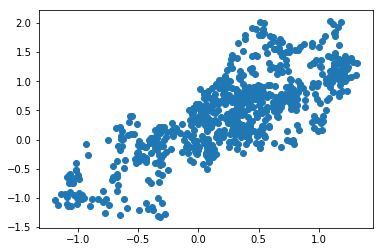

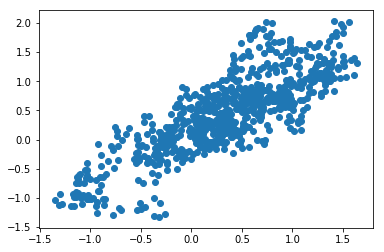

{'Iteration:  2099 \\/ 7000'}
-3.6465863069519413


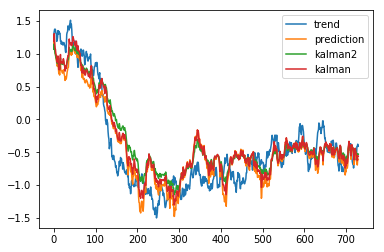

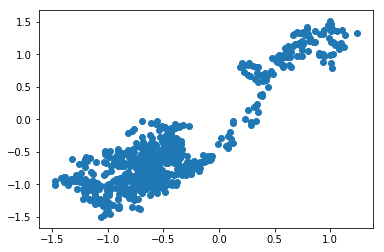

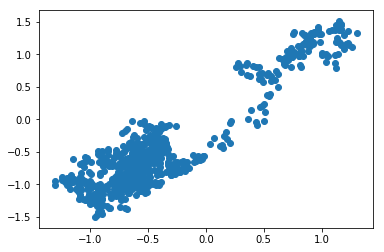

{'Iteration:  2199 \\/ 7000'}
-3.6466176229063434


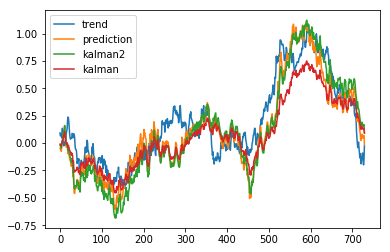

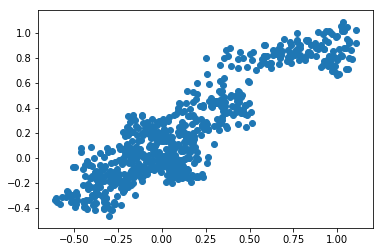

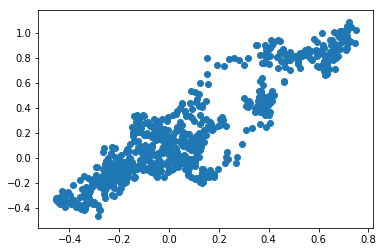

{'Iteration:  2299 \\/ 7000'}
-3.646703854762019


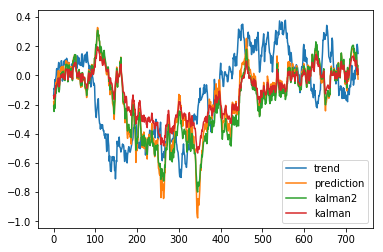

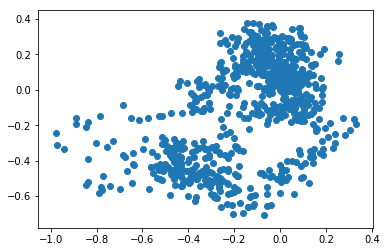

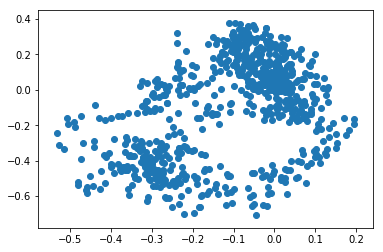

{'Iteration:  2399 \\/ 7000'}
-3.6466596136800957


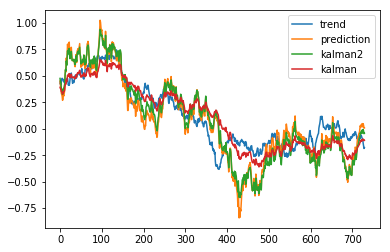

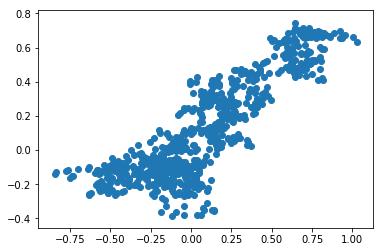

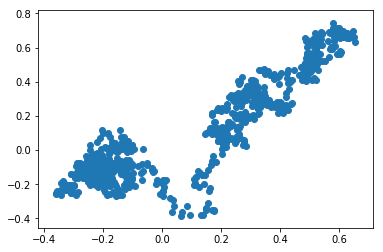

{'Iteration:  2499 \\/ 7000'}
-3.646549165574835


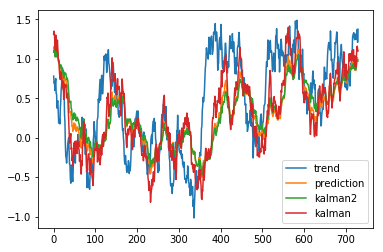

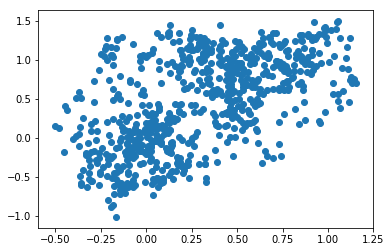

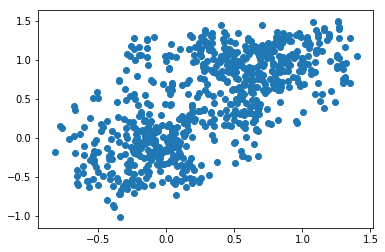

{'Iteration:  2599 \\/ 7000'}
-3.646033573523165


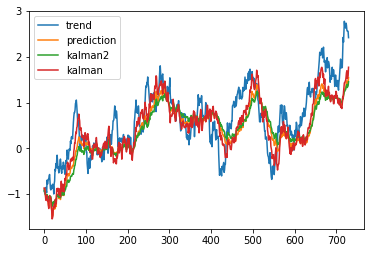

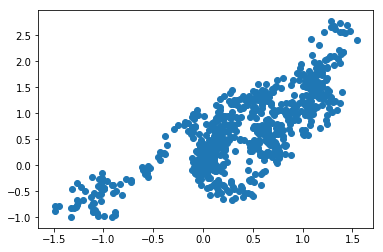

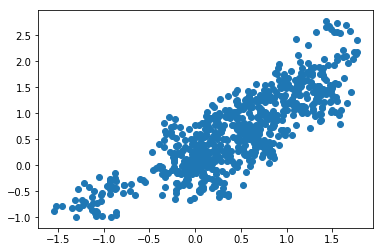

{'Iteration:  2699 \\/ 7000'}
-3.6465806831605745


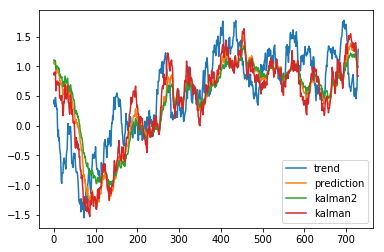

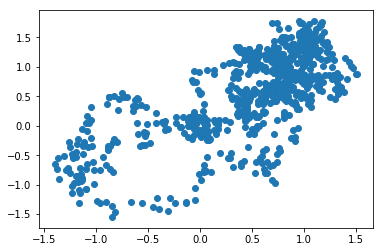

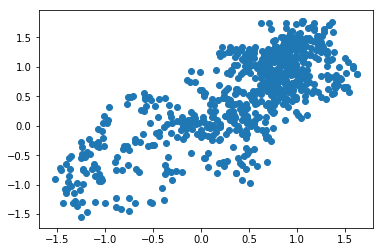

{'Iteration:  2799 \\/ 7000'}
-3.6467462124768657


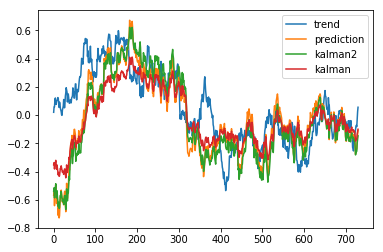

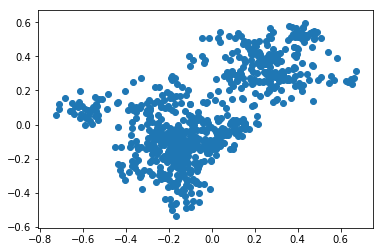

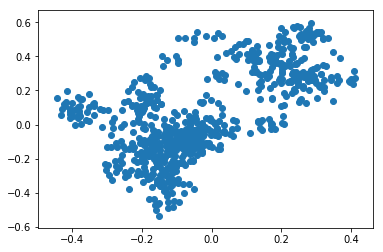

{'Iteration:  2899 \\/ 7000'}
-3.6467333683744085


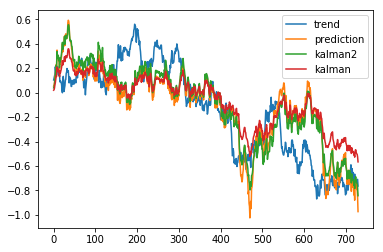

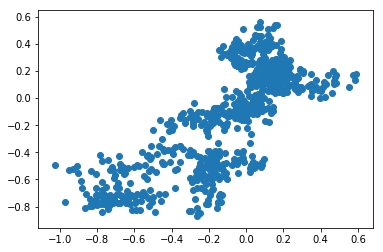

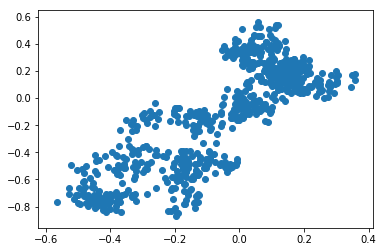

{'Iteration:  2999 \\/ 7000'}
-3.6465886296704424


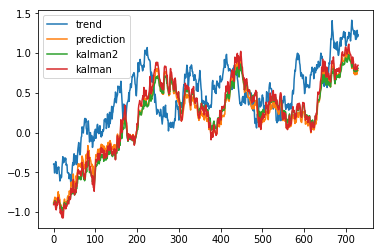

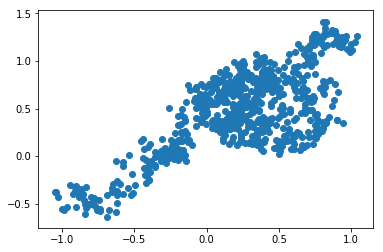

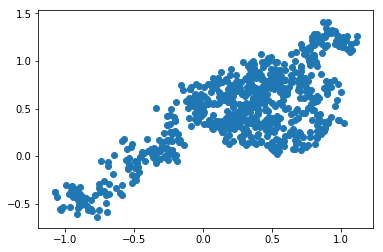

{'Iteration:  3099 \\/ 7000'}
-3.6467042282223714


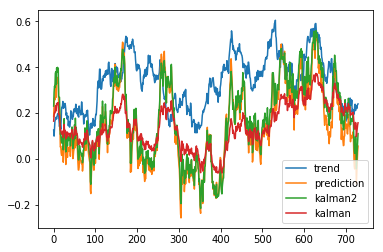

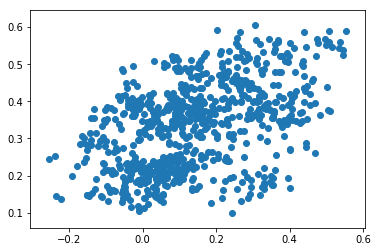

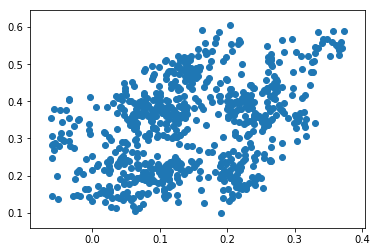

{'Iteration:  3199 \\/ 7000'}
-3.646174543630333


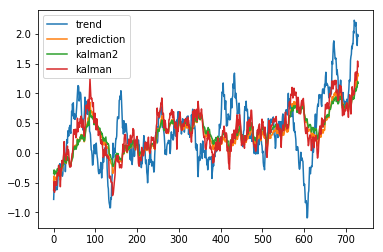

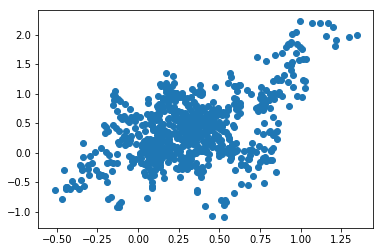

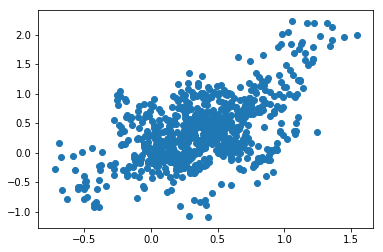

{'Iteration:  3299 \\/ 7000'}
-3.6465874340850872


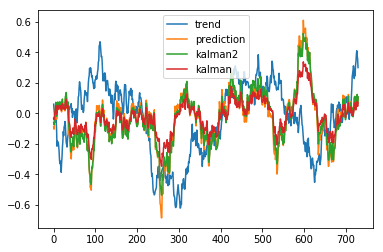

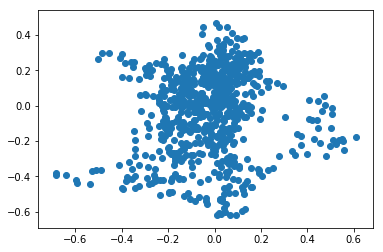

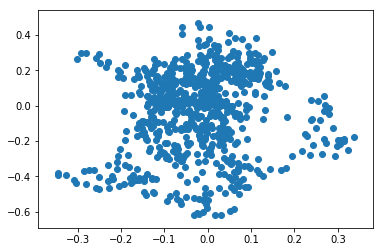

{'Iteration:  3399 \\/ 7000'}
-3.646566659305246


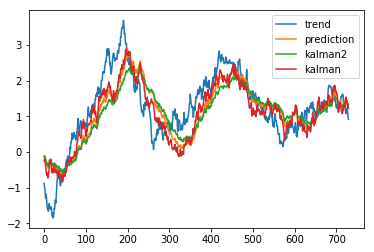

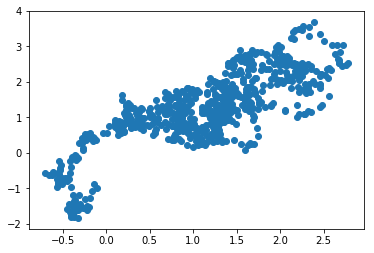

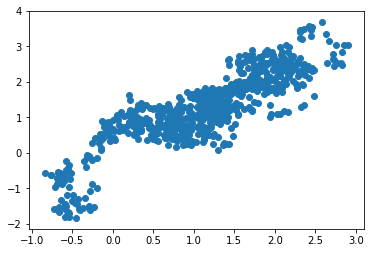

{'Iteration:  3499 \\/ 7000'}
-3.646504414128141


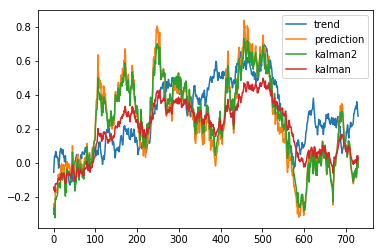

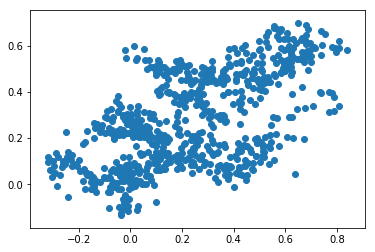

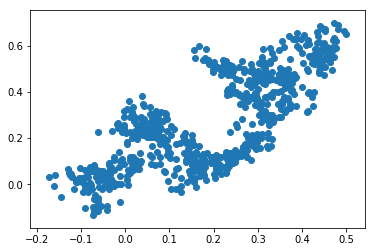

{'Iteration:  3599 \\/ 7000'}
-3.646655347524212


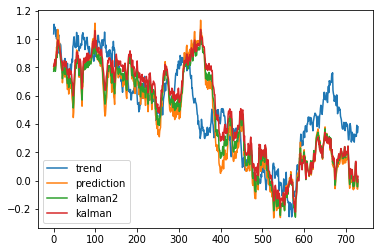

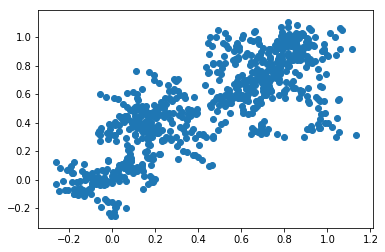

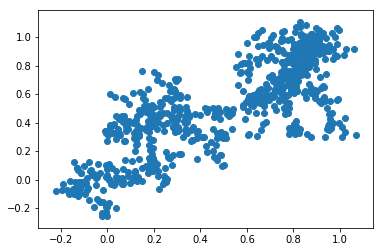

{'Iteration:  3699 \\/ 7000'}
-3.6465499977115554


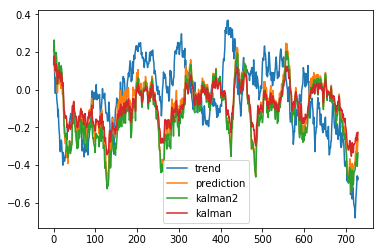

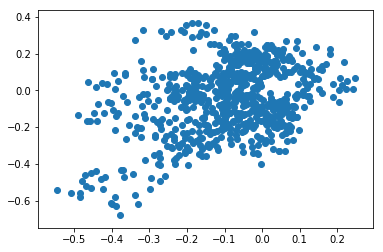

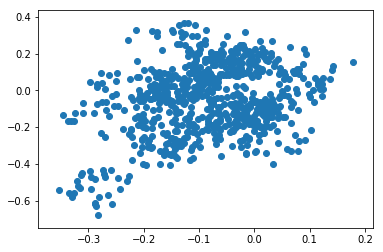

{'Iteration:  3799 \\/ 7000'}
-3.6467077746987355


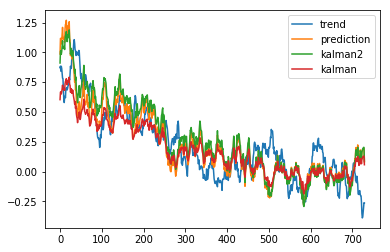

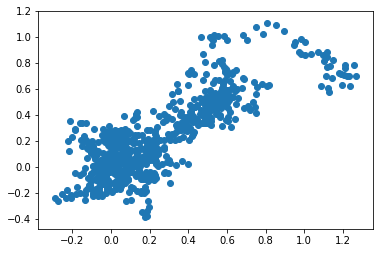

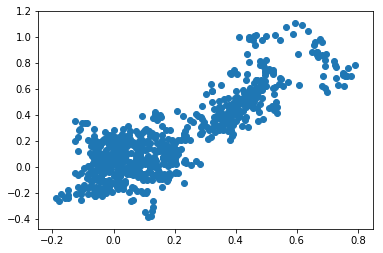

{'Iteration:  3899 \\/ 7000'}
-3.646598415775226


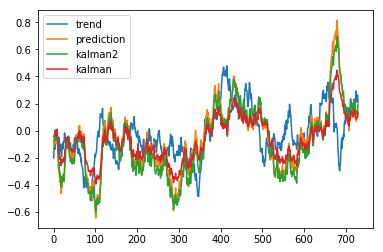

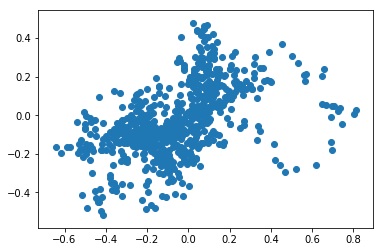

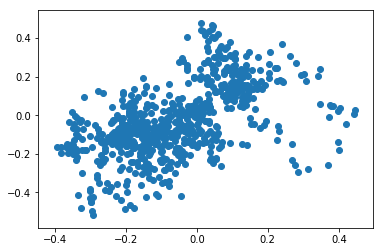

{'Iteration:  3999 \\/ 7000'}
-3.6466248844284577


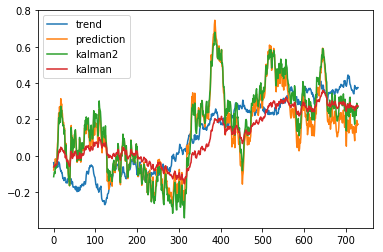

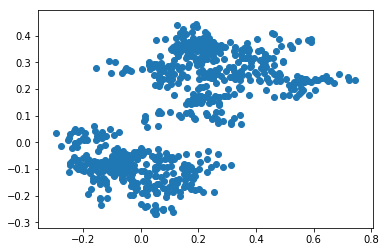

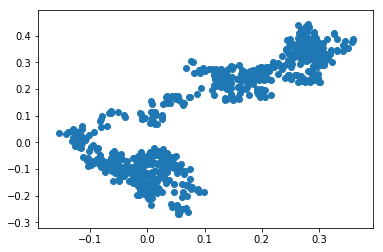

{'Iteration:  4099 \\/ 7000'}
-3.6465766498353345


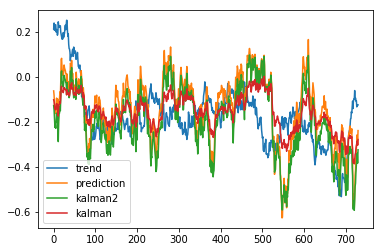

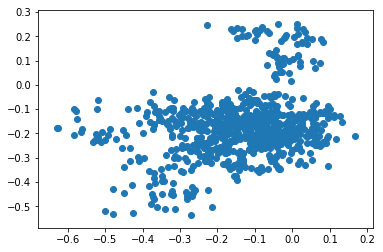

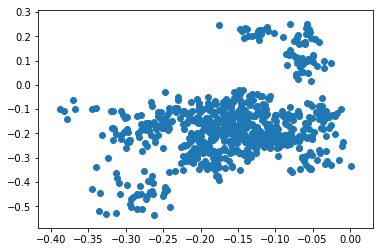

{'Iteration:  4199 \\/ 7000'}
-3.64661736842245


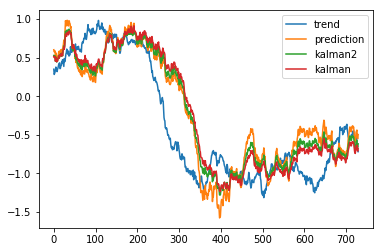

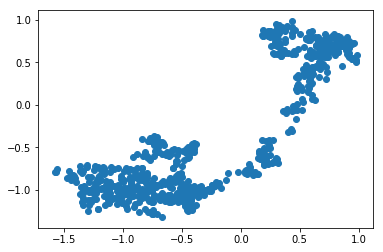

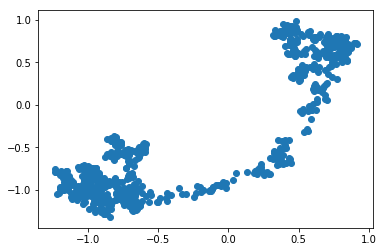

{'Iteration:  4299 \\/ 7000'}
-3.646636720141397


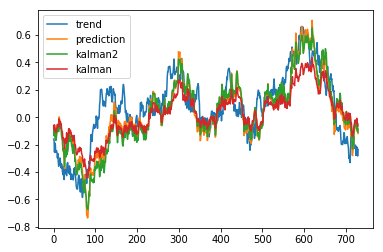

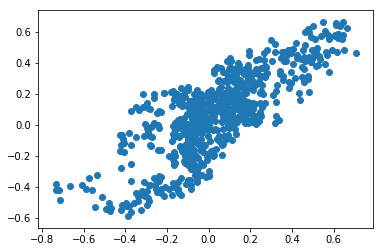

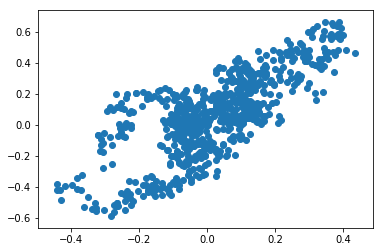

{'Iteration:  4399 \\/ 7000'}
-3.6465380928479147


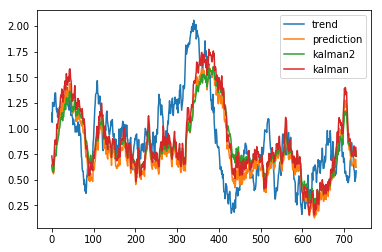

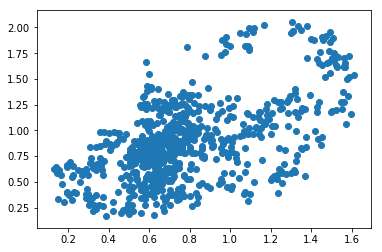

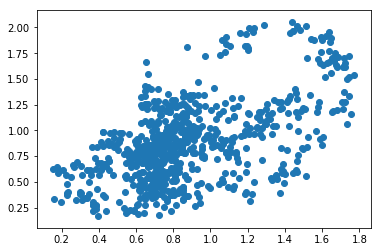

{'Iteration:  4499 \\/ 7000'}
-3.646515420963989


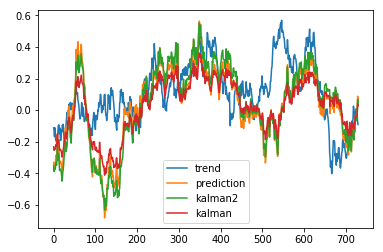

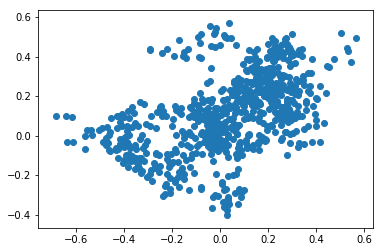

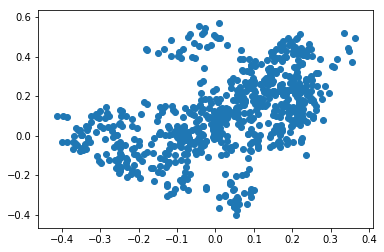

{'Iteration:  4599 \\/ 7000'}
-3.646768828481437


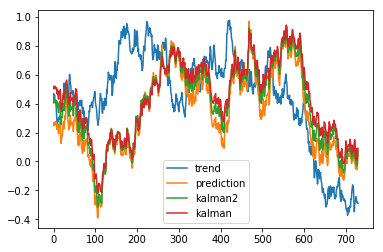

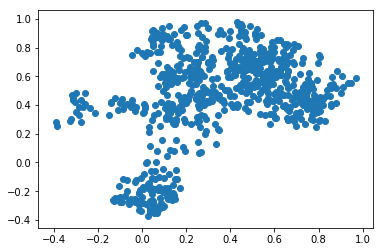

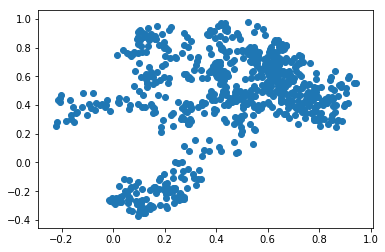

{'Iteration:  4699 \\/ 7000'}
-3.646553355827929


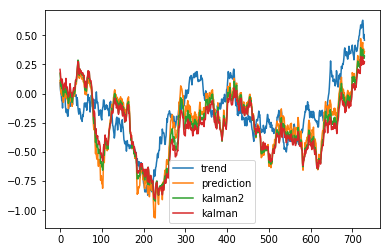

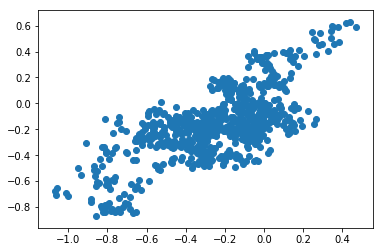

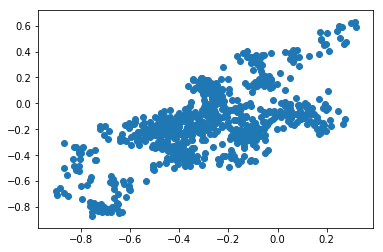

{'Iteration:  4799 \\/ 7000'}
-3.646634979732336


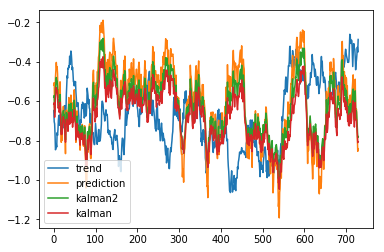

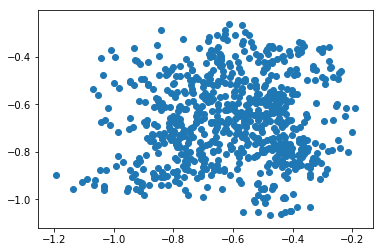

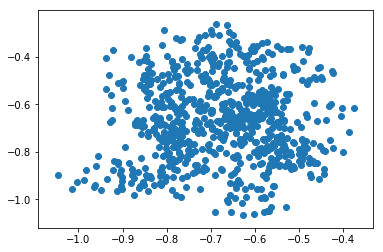

{'Iteration:  4899 \\/ 7000'}
-3.646605177409948


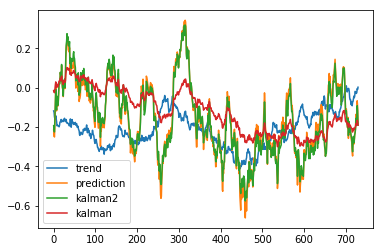

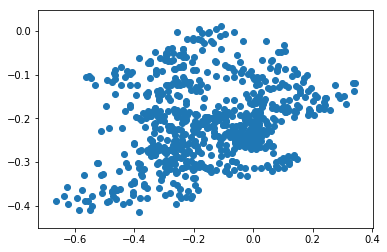

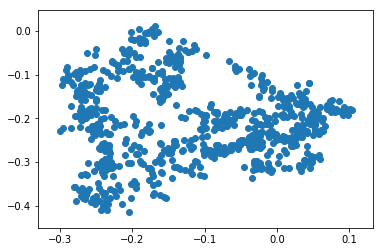

{'Iteration:  4999 \\/ 7000'}
-3.64646779568866


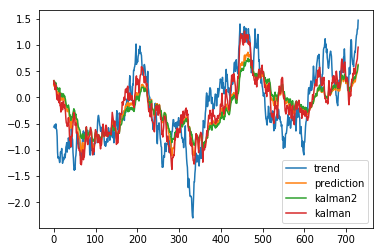

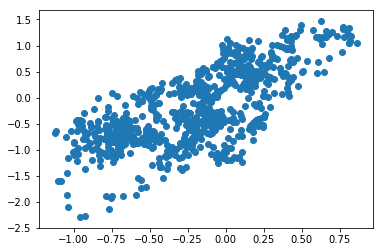

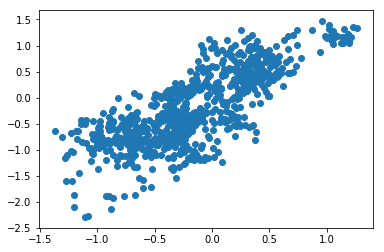

{'Iteration:  5099 \\/ 7000'}
-3.646525822672994


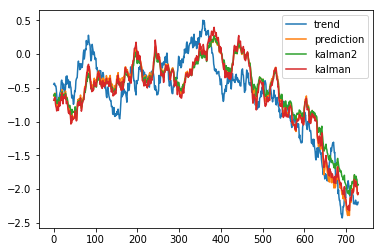

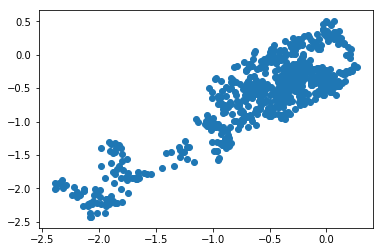

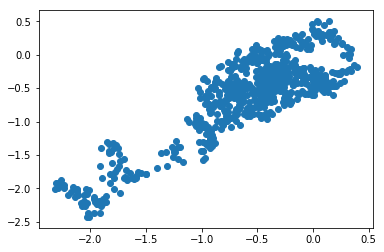

{'Iteration:  5199 \\/ 7000'}
-3.6465701356995863


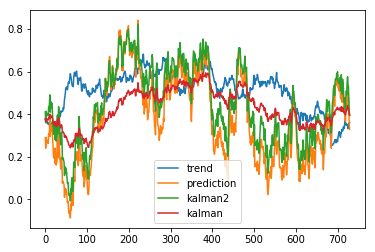

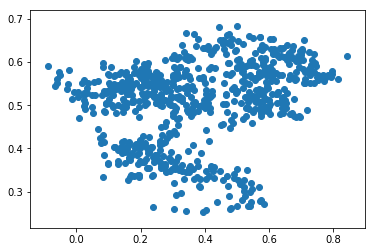

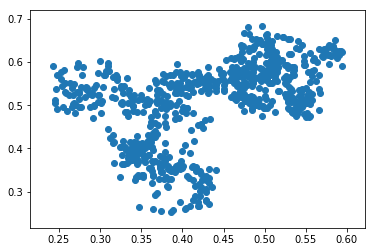

{'Iteration:  5299 \\/ 7000'}
-3.6464170439634485


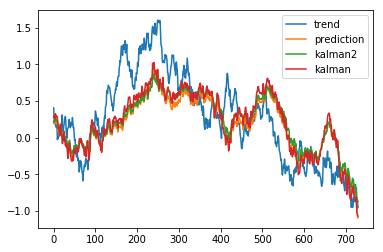

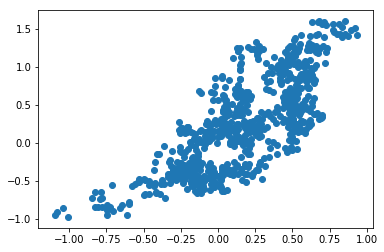

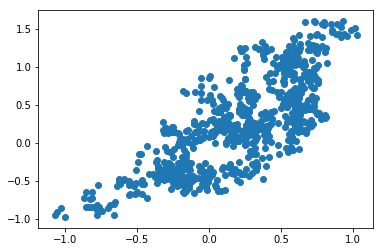

{'Iteration:  5399 \\/ 7000'}
-3.6466606250964118


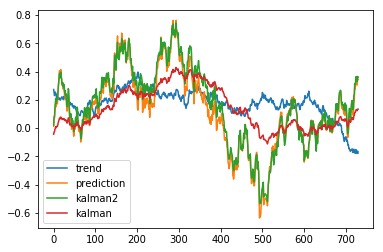

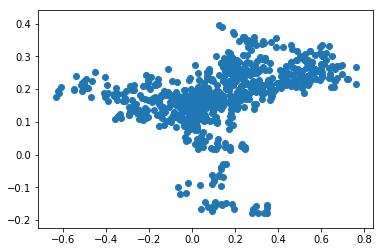

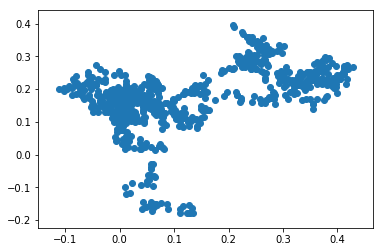

{'Iteration:  5499 \\/ 7000'}
-3.646619145618753


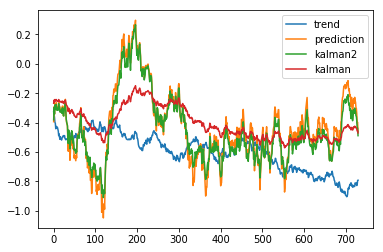

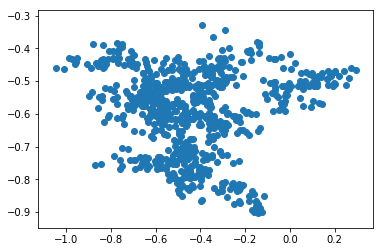

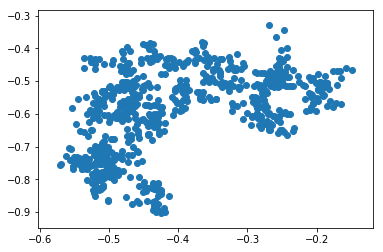

{'Iteration:  5599 \\/ 7000'}
-3.6465404339600367


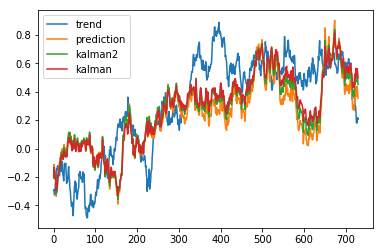

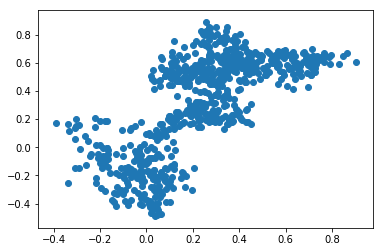

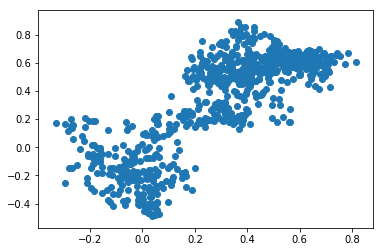

{'Iteration:  5699 \\/ 7000'}
-3.64664993886836


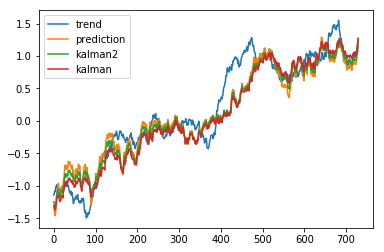

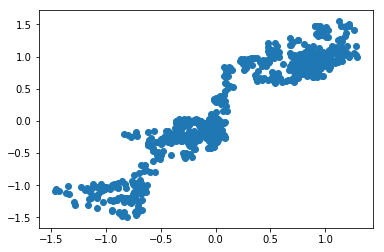

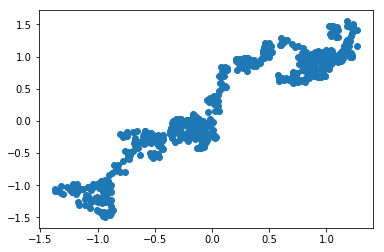

{'Iteration:  5799 \\/ 7000'}
-3.6466623685322714


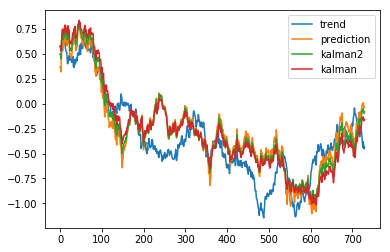

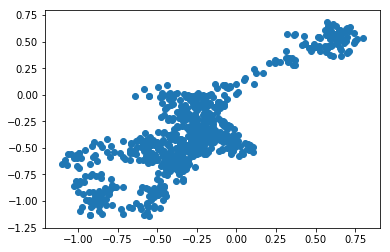

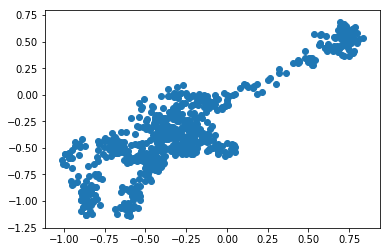

{'Iteration:  5899 \\/ 7000'}
-3.646468730270864


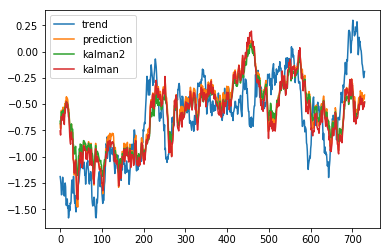

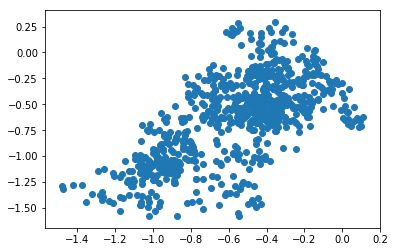

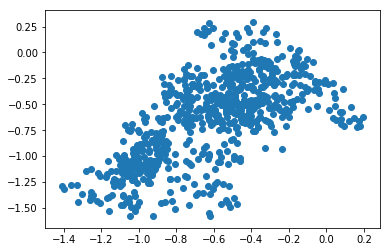

KeyboardInterrupt: 

In [11]:
writer = tf.summary.FileWriter(logs_dir, graph)
lrate = 0.001
N= 7000
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(N):
        X,Y ,trends, dicti= next(generator)
        state = sess.run( initial_state)

    
        
        if i==2250:
            lrate /= 10.
        if i==5000:
            lrate /= 10.
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: lrate,
               grad_clip: 0.1}
        if (i+1) %100 == 0 :
            print( { 'Iteration:  {} \/ {}'.format(i,N)})
            result = sess.run( [cost, outputs], feed_dict=feed)
            print( result[0]-noise**2)
            plt.plot( trends[1:,0][start:], label='trend')
            plt.plot( result[1][index,:,0][start:] , label='prediction')

            index=0
            lbd = 1
            sigma = 0.9
            sigmaS= 0.1
            deltaT= 1./365
            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                             sigmaS =sigmaS ,
                                             lbd=lbd,
                                             sigmamu= sigma,
                                             deltaT=deltaT )
            plt.plot(kalman_result[start:], label='kalman2' )

            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                                    sigmaS =noise/np.sqrt(365.) ,
                                                    lbd=dicti['lbd'],
                                                    sigmamu= dicti['sigma'],
                                                    deltaT=dicti['deltaT'] )
            plt.plot(kalman_result[start:], label='kalman' )
            plt.legend( loc='best')
            plt.show()
            plt.scatter( result[1][index,start:,0], trends[1:,0][start:])
            plt.show()
            plt.scatter( kalman_result[start:], trends[1:,0][start:])
            plt.show()
        sess.run( [optimizer], feed_dict=feed)
        ## print result
    for i in range(20):
        X,Y ,trends, dicti= next(generator)
        state = sess.run( initial_state)
        feed = { inputs_: X,
                initial_state :state,
               targets_: Y ,
               learning_rate: 0.001,
               grad_clip: 0.1}
        if i> -1 :
            result = sess.run( [cost, outputs], feed_dict=feed)
            print( result[0]-noise**2)
            plt.plot( trends[1:,0][start:], label='trend')
            plt.plot( result[1][index,:,0][start:] , label='prediction')

            index=0
            lbd = 1
            sigma = 0.9
            sigmaS= 0.1
            deltaT= 1./365
            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                             sigmaS =sigmaS ,
                                             lbd=lbd,
                                             sigmamu= sigma,
                                             deltaT=deltaT )
            plt.plot(kalman_result[start:], label='kalman2' )

            kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                                    sigmaS =noise/np.sqrt(365.) ,
                                                    lbd=dicti['lbd'],
                                                    sigmamu= dicti['sigma'],
                                                    deltaT=dicti['deltaT'] )
            plt.plot(kalman_result[start:], label='kalman' )
            plt.legend( loc='best')
            plt.show()
            plt.scatter( result[1][index,start:,0], trends[1:,0][start:])
            plt.show()
            plt.scatter( kalman_result[start:], trends[1:,0][start:])
            plt.show()
        

writer.close()   

In [ ]:
index=0
lbd = 1
sigma = 0.9
sigmaS= 0.1
deltaT= 1./365
dicti['sigma'] = 0.3
kalman_coeff1 =  kalman.kalman_coeff(sigmaS =sigmaS ,
                                    lbd=lbd,
                                    sigmamu= sigma,
                                    deltaT=deltaT )
kalman_coeff2 =  kalman.kalman_coeff(sigmaS =noise/np.sqrt(365.) ,
                                    lbd=dicti['lbd'],
                                    sigmamu= dicti['sigma'],
                                    deltaT=dicti['deltaT'] )
print( kalman_coeff1)
print(kalman_coeff2)


In [ ]:
kalman_result

In [ ]:
dicti

In [ ]:
index=0
lbd = 1
sigma = 0.9
sigmaS= 0.1
deltaT= 1./365
kalman_result =  kalman.kalman_estimate( X[index, :,0] ,
                                 sigmaS =sigmaS ,
                                 lbd=lbd,
                                 sigmamu= sigma,
                                 deltaT=deltaT )
plt.plot(kalman_result, label='kalman' )
#plt.plot(X[index,:,0])
plt.plot( result[1][index,:,0] , label = 'prediction')
plt.plot( trends[1:,0] , label= 'truth')
plt.legend( loc='best')
plt.show()

In [ ]:
plt.scatter( result[1][0,:,0], trends[1:,0])
plt.show()

In [ ]:
plt.plot(Y[0,:,0])
plt.show()